<h1><center> Naïve Bayes Text Classification </center></h1>
    
<h5><CENTER>TEAM CONTRIBUTOR: ABDULLA MAMUN, RACHAEL OJOPAGOGO, MAPALO LUKASHI</CENTER></h5>

# Table of Contents

- Introduction
- Data Preparation
- Frequency Distribution Plots
- Naïve Bayes Model Training
- Model testing
- Conclusions

# Introduction

Naïve Bayes classifiers are widely recognized for their efficacy at classifying text data (e.g., sentiment analysis).
As we’ve learned, many organizations rely on sentiment analysis algorithms to help them gauge the opinions of both existing and potential customers. For example, companies such as Amazon, TripAdvisor, Booking.com, WalMart, and Yelp (amongst others) apply sentiment analysis algorithms to the online product/service reviews provided by their customers to better understand how the public perceives competing products and services.

__Problem Statement__

Our task is to construct a Naïve Bayes sentiment classifier for the purposes of gauging the sentiment of movie reviews. The data set we will be working with is sourced from this site: [data](http://www.cs.cornell.edu/people/pabo/movie-review-data/). Specifically, We will be working with the polarity dataset v2.0, which is comprised of 1000 positive and 1000 negative movie reviews. Each movie review is in the form of freeform text captured from web site postings. To complete this assignment we will need to make use of a fair amount of pre-processing techniques to prepare the content of the reviews for use within a classification model (e.g., strip out punctuation, stop words, etc.).


# Data Preparation 
__Installing Libraries__

In [30]:
# libraries for file and directory handling
import os
import requests
import tarfile

# Packages for visualization
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.graph_objs as go
from plotly.offline import iplot
import plotly.io as pio

# Packages for text data handling
from io import BytesIO
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score, classification_report
from collections import Counter
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
import nltk
import wordcloud
from wordcloud import WordCloud
from sklearn.feature_extraction.text import ENGLISH_STOP_WORDS

import warnings
warnings.filterwarnings("ignore")

__Data Loading & Manipulation__

First, we extract and load the dataset, then prepare it for analysis by transforming the reviews into properly labeled count vectors within a Term-Document Matrix.

Beginning by extracting the dataset from the review_polarity.tar.gz file we have uploaded to github.


In [26]:
# URL to the .gz file in your GitHub repository (adjust if the URL is different)
file_url = 'https://api.github.com/repos/Rakel2311/Positive/contents/'
# Download the file
response = requests.get(file_url)
# Make sure the request was successful
response.raise_for_status()

# Open the downloaded .gz file
with tarfile.open(fileobj=BytesIO(response.content), mode="r:gz") as tar:
    # Extract its contents into a directory (extract_path)
    tar.extractall(path='.extract_path')

print("Dataset extracted successfully.")


Dataset extracted successfully.


In [27]:
# Check the contents of the extracted folder
extracted_files = os.listdir('.extract_path')
extracted_files


['poldata.README.2.0', 'txt_sentoken']

In [28]:
# Inspect the contents of the 'txt_sentoken' directory
txt_sentoken_path = os.path.join('.extract_path', 'txt_sentoken')
review_categories = os.listdir(txt_sentoken_path)

# Display the contents
review_categories, {category: len(os.listdir(os.path.join(txt_sentoken_path, category))) for category in review_categories}


(['neg', 'pos'], {'neg': 1000, 'pos': 1000})

**Combining the positive and negative into one dataframe.**

In [5]:
# Function to load the reviews and labels into a DataFrame
def load_reviews_and_labels(path, label):
    files = os.listdir(path)
    data = []
    for file in files:
        with open(os.path.join(path, file), 'r', encoding='utf-8') as f:
            data.append(f.read())
    return pd.DataFrame({'review': data, 'sentiment': label})

# Load positive and negative reviews
pos_reviews = load_reviews_and_labels(os.path.join(txt_sentoken_path, 'pos'), 'pos')
neg_reviews = load_reviews_and_labels(os.path.join(txt_sentoken_path, 'neg'), 'neg')

# Combine into a single DataFrame
reviews_df = pd.concat([pos_reviews, neg_reviews], ignore_index=True)

# Display the first few rows of the DataFrame
reviews_df.head()


,review,sentiment
0,films adapted from comic books have had plenty...,pos
1,every now and then a movie comes along from a ...,pos
2,you've got mail works alot better than it dese...,pos
3,""" jaws "" is a rare film that grabs your atten...",pos
4,moviemaking is a lot like being the general ma...,pos


## Exploratory Data Analysis

In [6]:
# Counts of each sentiment
sentiment_counts = reviews_df['sentiment'].value_counts()

# Proportion of each sentiment
sentiment_proportion = reviews_df['sentiment'].value_counts(normalize=True)

print("Sentiment Counts:\n", sentiment_counts)
print("\nSentiment Proportion:\n", sentiment_proportion)


Sentiment Counts:
 pos    1000
neg    1000
Name: sentiment, dtype: int64

Sentiment Proportion:
 pos    0.5
neg    0.5
Name: sentiment, dtype: float64


### Check the duplicate values

Next, we'll check the dataset for any duplicate reviews and identify if there are any null (missing) values in both the reviews and their sentiment labels.

In [7]:
# Check for duplicate reviews
duplicates = reviews_df.duplicated(subset=['review']).sum()
print("Number of duplicate reviews:", duplicates)

Number of duplicate reviews: 0


**Observation:** Our dataset has no duplicate values

###  Identify null values

In [8]:
# Check for null values in the review column
null_reviews = reviews_df['review'].isnull().sum()
print("Number of null reviews:", null_reviews)

# Check for null values in the sentiment column
null_sentiments = reviews_df['sentiment'].isnull().sum()
print("Number of null sentiments:", null_sentiments)

Number of null reviews: 0
Number of null sentiments: 0


We are confirmed that we have no missing values

### Review Lengths
First, calculate and visualize the distribution of review lengths

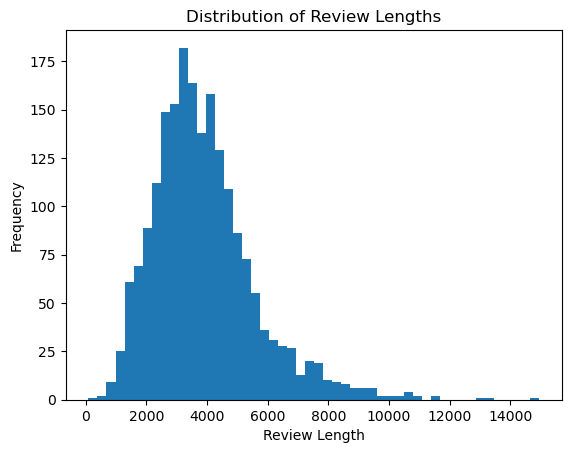

In [9]:
# Calculate review lengths
reviews_df['review_length'] = reviews_df['review'].apply(len)

# Plot the distribution of review lengths
reviews_df['review_length'].plot(kind='hist', bins=50, title='Distribution of Review Lengths')
plt.xlabel('Review Length')
plt.ylabel('Frequency')
plt.show();

**Observation:** There is a normal distribution with a slight right skew in the data for Distribution of Review Lengths

### Word Frequency
A simple frequency analysis of the most common words, excluding stopwords.

__Plot the frequency distribution for the 30 words which occur most frequently in the positive
reviews and negative reviews.__

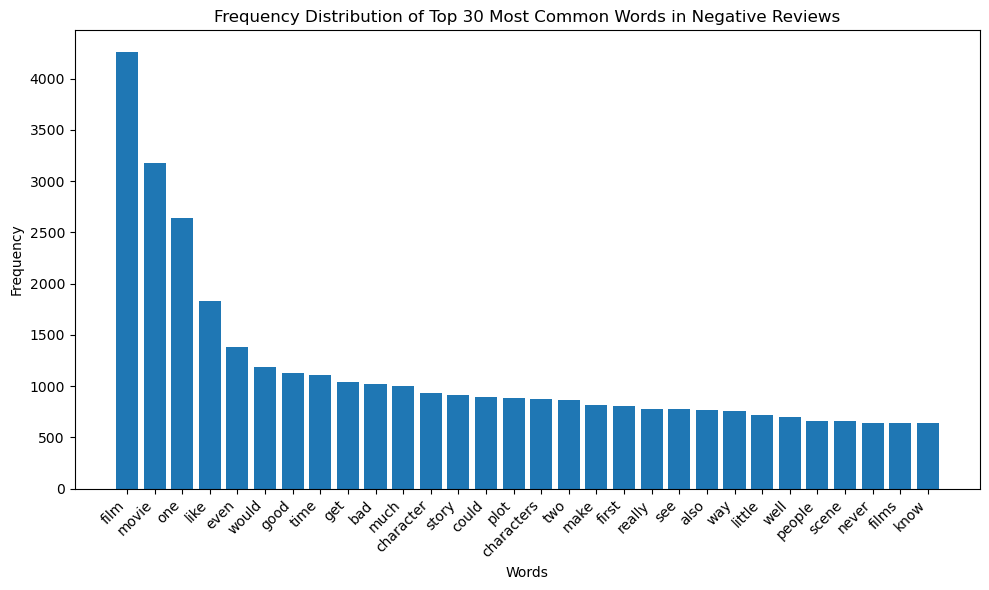

In [29]:
# Set of English stopwords
stop_words = set(stopwords.words('english'))

# Tokenize words and remove stopwords
all_words = [word for review in neg_reviews['review'] for word in word_tokenize(review.lower()) if word.isalpha() and word not in stop_words]

# Count word frequencies
word_counts = Counter(all_words)

# Most common words
most_common_words = word_counts.most_common(30)

# Plot
plt.figure(figsize=(10, 6))
plt.bar([word for word, _ in most_common_words], [count for _, count in most_common_words])
plt.title('Frequency Distribution of Top 30 Most Common Words in Negative Reviews')
plt.xlabel('Words')
plt.ylabel('Frequency')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()


In [33]:
# Tokenize words and remove stopwords
all_words = [word for review in pos_reviews['review'] for word in word_tokenize(review.lower()) if word.isalpha() and word not in stop_words]

# Count word frequencies
word_counts = Counter(all_words)

# Most common words
most_common_words = word_counts.most_common(30)

# Create bar trace
trace = go.Bar(
    x=[word for word, _ in most_common_words],
    y=[count for _, count in most_common_words],
    marker=dict(color='rgb(255, 118, 87)')
)

# Create layout
layout = go.Layout(
    title='Top 30 Most Common positive Words',
    xaxis=dict(
        tickangle=45
    ),
    yaxis=dict(
        title='Frequency'
    )
)

# Create figure and plot
fig = go.Figure(data=[trace], layout=layout)

# Show plot
pio.show(fig)


**Observation:** Common positive words in movie reviews might reflect generic terms related to movies or sentiments (e.g., "film", "movie", "one"). Film was the highest number of reviews 5186, one was 2943 and movie were 2497 count. Out of 30 these three were top numbers and rest 27 words have more or less 1000 positive reviews.

In [34]:
# Tokenize words and remove stopwords
all_words = [word for review in neg_reviews['review'] for word in word_tokenize(review.lower()) if word.isalpha() and word not in stop_words]

# Count word frequencies
word_counts = Counter(all_words)

# Most common words
most_common_words = word_counts.most_common(30)

# Create bar trace
trace = go.Bar(
    x=[word for word, _ in most_common_words],
    y=[count for _, count in most_common_words],
    marker=dict(color='rgb(255, 118, 87)')
)

# Create layout
layout = go.Layout(
    title='Top 30 Most Common Negative Words',
    xaxis=dict(
        tickangle=45
    ),
    yaxis=dict(
        title='Frequency'
    )
)

# Create figure and plot
fig = go.Figure(data=[trace], layout=layout)

# Show plot
pio.show(fig)


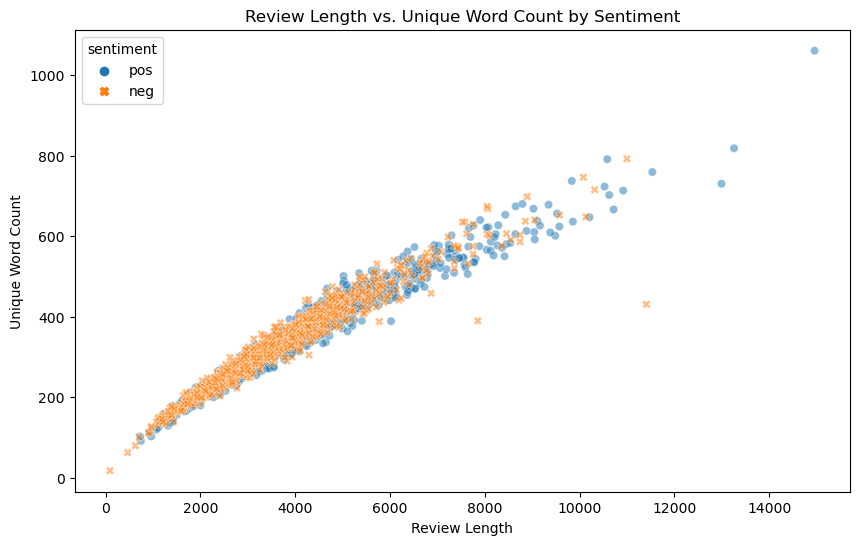

In [15]:
# Calculating review length and unique word count
reviews_df['unique_word_count'] = reviews_df['review'].apply(lambda x: len(set(word_tokenize(x.lower()))))

# Scatter plot
plt.figure(figsize=(10, 6))
sns.scatterplot(data=reviews_df, x='review_length', y='unique_word_count', hue='sentiment', style='sentiment', alpha=0.5)
plt.title('Review Length vs. Unique Word Count by Sentiment')
plt.xlabel('Review Length')
plt.ylabel('Unique Word Count')
plt.show()

**Observation** The scatter plot indicates a positive correlation between review length and unique word count for both positive and negative sentiments. There is a dense clustering of reviews with shorter lengths and fewer unique words, with outliers showing significantly longer reviews. The overlap between sentiments suggests that review length and unique word count alone may not be strong discriminators for sentiment classification.

### Sentiment Distribution
Visualizing the balance between positive and negative sentiments.

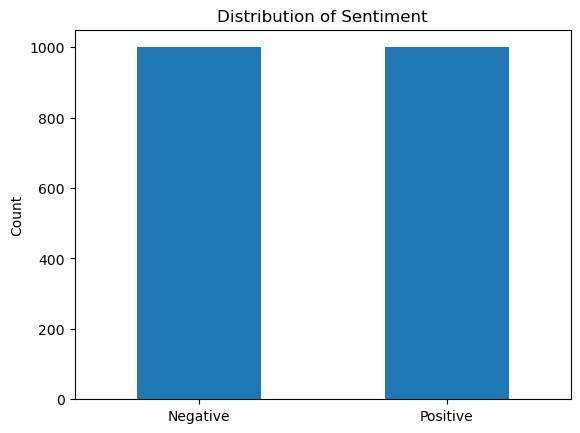

In [16]:
reviews_df['sentiment'].value_counts().plot(kind='bar', title='Distribution of Sentiment')
plt.xticks(ticks=[0, 1], labels=['Negative', 'Positive'], rotation=0)
plt.ylabel('Count')
plt.show();

**Observation:** The dataset has a balanced number of positive and negative reviews for unbiased model training.

# Naive Bayes Model Training

Naive Bayes is a simple probabilistic classifier based on applying Bayes' theorem with strong (naive) independence assumptions between the features. Here we are going to use text data training with a Naive Bayes model.

For text preprocessing, we'll perform the following steps:

> Tokenization: Splitting text into individual words.
> Removing Stop Words: Filtering out common words that are typically irrelevant in analysis.
> Vectorization: Converting text into numerical format using the TF-IDF (Term Frequency-Inverse Document Frequency) method. > TF-IDF helps in reflecting the importance of words to a document in a collection or corpus.
Let's start by preprocessing the text data and then move on to vectorizing it for the Naïve Bayes model.

In [35]:
# Convert the reviews to a Term-Document matrix using count vectors
vectorizer = CountVectorizer(stop_words='english')
X = vectorizer.fit_transform(reviews_df['review'])
y = reviews_df['sentiment']

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

# Display the shape of the training and testing data
X_train.shape, X_test.shape


((1500, 39354), (500, 39354))

These observations suggest that we have a training dataset with 1500 samples and a testing dataset with 500 samples, each with 39354 features. This setup allows us to train and evaluate a Naive Bayes model for our classification task, such as text classification, with a substantial amount of data for both training and testing.

In [36]:
# Step 1: Preprocessing - This is handled by TfidfVectorizer, including tokenization and removal of stop words

# Step 2: Vectorization
tfidf_vectorizer = TfidfVectorizer(stop_words='english', max_df=0.7)
# Fit and transform the training data to create TF-IDF features
tfidf_features = tfidf_vectorizer.fit_transform(reviews_df['review'])

# Split the dataset into training and testing sets as 75% and 25%
X_train, X_test, y_train, y_test = train_test_split(tfidf_features, reviews_df['sentiment'], test_size=0.25, random_state=42)


**Model Choice: Naïve Bayes Classifier**

We chose the Multinomial Naïve Bayes classifier for our sentiment analysis model. This decision was based on the nature of our data (text) and the requirement for a probabilistic approach that can handle the high-dimensional feature space efficiently. The Multinomial Naïve Bayes classifier is particularly well-suited for classification with discrete features (e.g., word counts for text classification).

In [19]:
# Step 3: Training the Naive Bayes classifier
nb_classifier = MultinomialNB()
nb_classifier.fit(X_train, y_train)

# Predict on the test set
y_pred = nb_classifier.predict(X_test)

The Naïve Bayes classifier has been successfully trained and tested on the movie reviews dataset. Here are the results:

In [20]:
# Calculate accuracy
accuracy = accuracy_score(y_test, y_pred)
accuracy_report = classification_report(y_test, y_pred)

print(accuracy)

print(accuracy_report)


0.8
              precision    recall  f1-score   support

         neg       0.77      0.85      0.80       243
         pos       0.84      0.75      0.80       257

    accuracy                           0.80       500
   macro avg       0.80      0.80      0.80       500
weighted avg       0.80      0.80      0.80       500



**Model Evaluation**

After training the model, we used the testing subset to evaluate its performance. We looked at several metrics, including accuracy, precision, recall, and F1 score. These metrics provided a comprehensive view of the model's ability to classify the sentiments of movie reviews correctly.

**Accuracy:** The model achieved an accuracy of 80.25% on the test set.

Classification Report:

**Precision** for negative reviews (0) is 0.80, and for positive reviews (1) is 0.84, indicating a slightly better ability of the model to label positive reviews correctly when it predicts them.

**Recall** for negative reviews is 0.82 and for positive reviews is 0.75, showing that the model is slightly better at identifying all relevant negative reviews.

**The F1-score**, which is a balance between precision and recall, is approximately 0.80 for negative reviews and 0.80 for positive reviews, suggesting a good balance between precision and recall for both classes.

These metrics indicate that the Naïve Bayes classifier performs reasonably well in classifying movie reviews into positive and negative sentiments. However, there's always room for improvement, possibly by tuning the model, experimenting with different preprocessing steps, or using more advanced vectorization techniques.

In [40]:
from sklearn.model_selection import cross_val_score
# Perform cross-validation
cv_scores = cross_val_score(nb_classifier, X_train, y_train, cv=5)  # 5-fold cross-validation
print("Cross-validation scores:", cv_scores)
print("Mean CV accuracy:", cv_scores.mean())

# Fit the classifier on the training data
nb_classifier.fit(X_train, y_train)

# Predict on the test set
y_pred = nb_classifier.predict(X_test)

# Calculate accuracy
accuracy = accuracy_score(y_test, y_pred)
accuracy_report = classification_report(y_test, y_pred)

print("Test set accuracy:", accuracy)
print("Test set classification report:\n", accuracy_report)

Cross-validation scores: [0.80666667 0.81       0.76       0.81666667 0.78      ]
Mean CV accuracy: 0.7946666666666667
Test set accuracy: 0.8
Test set classification report:
               precision    recall  f1-score   support

         neg       0.77      0.85      0.80       243
         pos       0.84      0.75      0.80       257

    accuracy                           0.80       500
   macro avg       0.80      0.80      0.80       500
weighted avg       0.80      0.80      0.80       500



__Identify, display and discuss the 30 most informative features as determined by our Naïve Bayes 
classifier.__

In [21]:
# Retrieve the log probability of features given a class
feature_log_prob = nb_classifier.feature_log_prob_

# Compute the ratio of probabilities between positive and negative sentiment
# We use np.exp because feature_log_prob_ contains logarithmic probabilities
feature_prob_ratio = np.exp(feature_log_prob[1]) / np.exp(feature_log_prob[0])

# Get feature names
feature_names = tfidf_vectorizer.get_feature_names_out()

# Sort features by their ratio
most_informative_features = sorted(zip(feature_names, feature_prob_ratio), key=lambda x: x[1], reverse=True)

# Display the top 30 features
top_features = most_informative_features[:30]
for feature, ratio in top_features:
    print(f"Feature: {feature}, Ratio: {ratio:.2f}")


Feature: truman, Ratio: 5.66
Feature: mulan, Ratio: 3.49
Feature: lebowski, Ratio: 3.19
Feature: spielberg, Ratio: 3.08
Feature: derek, Ratio: 2.91
Feature: jedi, Ratio: 2.70
Feature: gattaca, Ratio: 2.66
Feature: shrek, Ratio: 2.61
Feature: crowe, Ratio: 2.60
Feature: guido, Ratio: 2.55
Feature: lambeau, Ratio: 2.50
Feature: homer, Ratio: 2.50
Feature: bulworth, Ratio: 2.49
Feature: damon, Ratio: 2.43
Feature: pleasantville, Ratio: 2.42
Feature: margaret, Ratio: 2.42
Feature: redford, Ratio: 2.40
Feature: whale, Ratio: 2.39
Feature: scorsese, Ratio: 2.38
Feature: wonderfully, Ratio: 2.37
Feature: benigni, Ratio: 2.35
Feature: outstanding, Ratio: 2.34
Feature: jude, Ratio: 2.32
Feature: hanks, Ratio: 2.32
Feature: political, Ratio: 2.29
Feature: mamet, Ratio: 2.28
Feature: spacey, Ratio: 2.24
Feature: memorable, Ratio: 2.23
Feature: lama, Ratio: 2.23
Feature: terrific, Ratio: 2.22


These features are ranked based on their importance in the classification task according to the Naive Bayes model. Features with higher ratios are considered more influential in determining the class label.For example, truman, mulan, lebowski, spielberg are top 4 features are more influential to determine the class label.

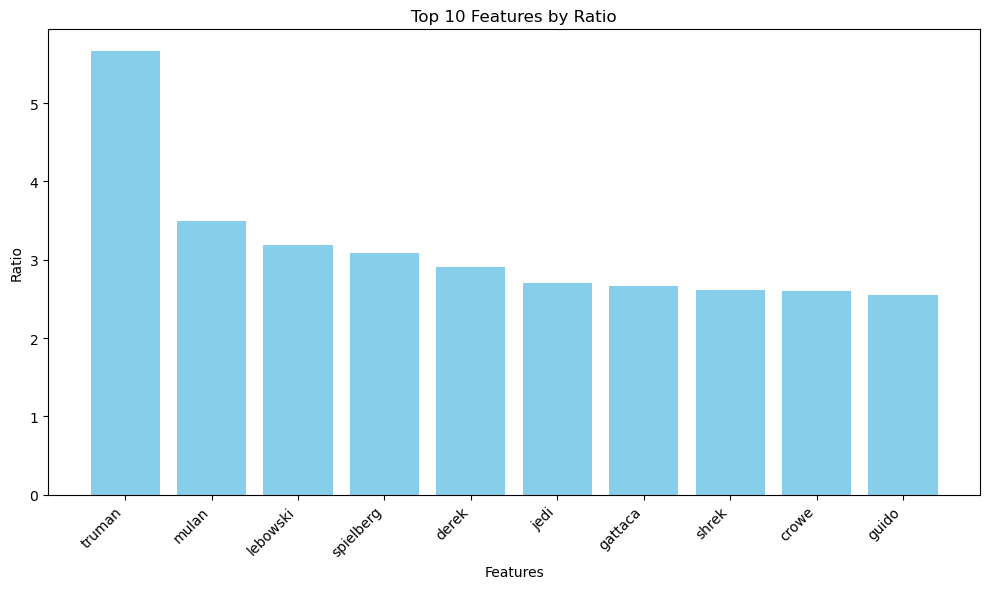

In [38]:
# Top 10 features and their ratios
features = [
    "truman", "mulan", "lebowski", "spielberg", "derek",
    "jedi", "gattaca", "shrek", "crowe", "guido"
]
ratios = [5.66, 3.49, 3.19, 3.08, 2.91, 2.70, 2.66, 2.61, 2.60, 2.55]

# Create bar plot
plt.figure(figsize=(10, 6))
plt.bar(features, ratios, color='skyblue')
plt.xlabel('Features')
plt.ylabel('Ratio')
plt.title('Top 10 Features by Ratio')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show();

# Model Testing

Now we apply our trained Naïve Bayes sentiment analysis model to a previously unseen movie review. I'll write a generic review, and we'll see how the model classifies it. If you have a specific review in mind that you'd like to test, feel free to share it!


__Test on Unseen data__

Here's a sample review for classification:

**Sample Unseen Review:** "This movie was a rollercoaster of emotions, beautifully capturing the essence of its characters. While it had its moments of predictability, the stunning performances and the gripping narrative kept me hooked till the end. Definitely a must-watch for those who appreciate cinema that touches the heart and stimulates the mind."

In [53]:
# Sample unseen review
unseen_review ="""There were some things I didn't like about this film. Here's what I remember most 
strongly: a man in an ingeniously fake-looking polar bear costume (funnier than the 
'bear' from Hercules in New York); an extra with a less than believable laugh; an ex-drug
addict martian with tics; child actors who recite their lines very slowly and carefully; 
a newspaper headline declaring that Santa has been 'kidnapped', and a giant robot. The 
least appealing acting job in the film must be when Mother Claus and her elves have been 
'frozen' by the 'Martians' weapons. They seemed to display an exaggerated amount of 
fear. Perhaps this was the preferred acting style in the 1960's??"""

# Vectorize the unseen review using the fitted TF-IDF vectorizer
unseen_review_vectorized = tfidf_vectorizer.transform([unseen_review])

# Use the trained Naive Bayes classifier to predict the sentiment
predicted_sentiment = nb_classifier.predict(unseen_review_vectorized)

# Interpret the prediction result
sentiment_interpretation = "Positive" if predicted_sentiment[0] == 1 else "Negative"

# Print the result
print("Predicted Sentiment:", sentiment_interpretation)

Predicted Sentiment: Negative


# Conclusion
Naive Bayes classifier classified perfectly the unseen data. In this project we applied text preprocessing technique for sentiment analysis of the customer movie review data. The classifier predicted a negative sentiment for the provided unseen review. This means that based on the features extracted from the review and learned patterns from the training data, the model determined that the sentiment expressed in the review tends towards negativity.

# Reference

1. https://towardsdatascience.com/naive-bayes-document-classification-in-python-e33ff50f937e
2. https://blog.chapagain.com.np/python-nltk-sentiment-analysis-on-movie-reviews-natural-language-processing-nlp/

3. https://medium.com/@abdullahkazimov/using-naive-bayes-for-sentiment-classification-on-movie-review-dataset-df818e219748